# Step 1: 取得 DATASET

In [ ]:
!cp "/content/drive/MyDrive/以 DIPCV Techniques 優化繁體中文手寫辨識模型之精準度與信心/JJ_30.zip" "JJ_30.zip"
!unzip JJ_30.zip

!cp "/content/drive/MyDrive/以 DIPCV Techniques 優化繁體中文手寫辨識模型之精準度與信心/Single_Block_OK.zip" "Single_Block_OK.zip"
!unzip Single_Block_OK.zip

!cp "/content/drive/MyDrive/以 DIPCV Techniques 優化繁體中文手寫辨識模型之精準度與信心/without_cross_black_background_119.zip" "without_cross_black_background_119.zip"
!unzip without_cross_black_background_119.zip

!cp "/content/drive/MyDrive/以 DIPCV Techniques 優化繁體中文手寫辨識模型之精準度與信心/without_cross_white_background_119.zip" "without_cross_white_background_119.zip"
!unzip without_cross_white_background_119.zip

!cp "/content/drive/MyDrive/以 DIPCV Techniques 優化繁體中文手寫辨識模型之精準度與信心/cropped_resize_100.zip" "cropped_resize_100.zip"
!unzip cropped_resize_100.zip

!cp "/content/drive/MyDrive/以 DIPCV Techniques 優化繁體中文手寫辨識模型之精準度與信心/Attr_Table.csv" "Attr_Table.csv"

In [55]:
# Loop! Iterable

collection_1 = "ABCDEFGHIJK"
collection_2 = ["Apple", "Banana", "Cake", "Dad", "Eric"]
collection_3 = {"key1": 0, "key2": 1, "key3": 2, "key4": 3, "key5":4, "Eric":174}
collection_4 = range(100)

for val in collection_3:
  print(val)

key1
key2
key3
key4
key5
Eric


In [60]:
!ls "JJ_30/"

0   13	18  22	27  31	36  40	45  5	54  59	63  68	72  77	81
1   14	19  23	28  32	37  41	46  50	55  6	64  69	73  78	82
10  15	2   24	29  33	38  42	47  51	56  60	65  7	74  79	9
11  16	20  25	3   34	39  43	48  52	57  61	66  70	75  8
12  17	21  26	30  35	4   44	49  53	58  62	67  71	76  80


In [62]:
# for loop

import os

PATH_TO_FOLDER="JJ_30/"
type(os.listdir(PATH_TO_FOLDER))

list

In [67]:
for class_name in os.listdir(PATH_TO_FOLDER):
  for img_name in os.listdir(PATH_TO_FOLDER+class_name):
    path_to_img = PATH_TO_FOLDER+class_name+"/"+img_name
    read_and_plot_img(path_to_img)  

Output hidden; open in https://colab.research.google.com to view.

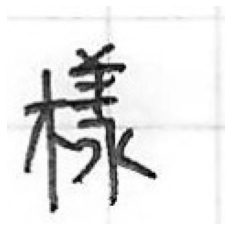

In [66]:
import cv2 as cv
import matplotlib.pyplot as plt

def read_and_plot_img(path_to_img):
  img_test = cv.imread(path_to_img)
  img_test_gray = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
  plt.imshow(img_test_gray, cmap="gray")
  plt.axis("off")
  plt.show()

path_to_img = "JJ_30/53/0908_283.jpg"
read_and_plot_img(path_to_img)

In [4]:
# recursion

def number_of_choices(num):
  if num == 1: # base
    return 1
  elif num == 2: # base
    return 2
  else: # normal
    return number_of_choices(num-2) + number_of_choices(num-1)

number_of_choices(10)

89

# STEP 2: 初步觀察 Data

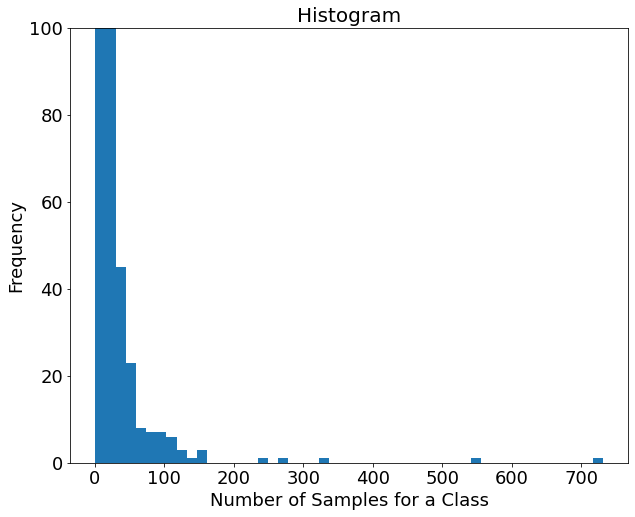

In [ ]:
import matplotlib.pyplot as plt
import os

tmp_list = []
for one_folder in os.listdir("Single_Block"):
  tmp_list.append(len(os.listdir(f"Single_Block/{one_folder}")))

plt.figure(figsize=(10,8))
plt.hist(tmp_list, bins=50)
plt.title("Histogram", fontsize=20)
plt.xlabel("Number of Samples for a Class", fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,100)
plt.show()

# Step 2.5: 使用 Attr Table

In [ ]:
import pandas as pd

attr_table = pd.read_csv("Attr_Table.csv")
attr_np = attr_table.to_numpy()
attr_np

array([[   0,    1,    1],
       [   1,    0,    2],
       [   2,    0,    1],
       ...,
       [1174,    0,   17],
       [1175,    0,   13],
       [1176,    1,   13]])

In [ ]:
attr_np[:,0] # 可以取得 folder name
attr_np[:,1] # 可以取得 是否對稱
attr_np[:,2] # 可以取得 num_stroke

array([ 1,  2,  1, ..., 17, 13, 13])

In [ ]:
attr_np[100]

12

In [ ]:
def provide_num_stroke(folder_name, attr_np):
  int_folder_name = int(folder_name)
  num_stroke = attr_np[int_folder_name][2]
  return num_stroke/10

def provdie_symmetry(folder_name, attr_np):
  int_folder_name = int(folder_name)
  symmetry = attr_np[int_folder_name][1]
  return symmetry

In [ ]:
print("筆劃數", provide_num_stroke("15", attr_np))
print("是否對稱", provdie_symmetry("15", attr_np))

筆劃數 0.3
是否對稱 1


# Step 3: 準備訓練資料集

In [ ]:
#JJDataPath = "/content/JJ_30/"
#JJDataPath = "/content/Single_Block/"
#JJDataPath = "/content/without_cross_black_background_119/"
#JJDataPath = "/content/without_cross_white_background_119/"
JJDataPath = "/content/cropped_resize_100/"

In [ ]:
def perform_logical_and(img):
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)/255
  img = 1 - img
  left_part = img[:, :50]
  right_part = img[:, 50:]
  overlap = np.sum(np.logical_and(left_part, right_part[:,::-1]))
  return overlap/1000

In [ ]:
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2 as cv
import numpy as np

Image_List=list()
Attr_List=list()
if JJDataPath == "/content/JJ_30/" or JJDataPath == "/content/Single_Block/":
  for folder_name in tqdm(os.listdir(JJDataPath)):
    for img_name in os.listdir(JJDataPath+folder_name):
      tmp_img = cv.imread(JJDataPath+folder_name+"/"+img_name)
      Image_List.append(tmp_img)
      if np.any(np.isnan(tmp_img)) == True:
        print(JJDataPath+folder_name+"/"+img_name)
      attr_1 = 1 # 未來塞 function 用 偵測直線
      attr_2 = 2 # 未來塞 function 用 偵測橫線
      attr_3 = 3 # 未來塞 function 用 偵測字跡有多長
      attr_4 = 4 # 未來塞 function 用 左右對稱的分數
      attr_length = len([folder_name, attr_1, attr_2, attr_3, attr_4])
      Attr_List.append([folder_name, attr_1, attr_2, attr_3, attr_4])

if JJDataPath == "/content/cropped_resize_100/" or JJDataPath == "/content/without_cross_black_background_119/" or JJDataPath == "/content/without_cross_white_background_119/":
  for image_name in tqdm(os.listdir(JJDataPath)):
    tmp_img = cv.imread(JJDataPath+image_name)
    Image_List.append(tmp_img)
    if np.any(np.isnan(tmp_img)) == True:
      print(JJDataPath+image_name)
    folder_name = image_name.split("_")[0]
    attr_1 = 1 # 未來引入 偵測直線數量
    attr_2 = provide_num_stroke(folder_name, attr_np)
    #attr_2 = 2 # 未來引入 num of stoke
    #attr_3 = provdie_symmetry(folder_name, attr_np)
    attr_3 = 3 # 未來引入 偵測字是否左右對稱
    #attr_4 = perform_logical_and(tmp_img)
    attr_4 = 4 # 未來引入 Logical And 的分數
    attr_length = len([folder_name, attr_1, attr_2, attr_3, attr_4])
    Attr_List.append([folder_name, attr_1, attr_2, attr_3, attr_4])

#Image_List = np.array(Image_List)
tranImgX, valImgX, tranAttr, valAttr = train_test_split(Image_List, Attr_List, test_size=0.2, random_state=41)

dim1 = len(tranImgX)
tranImgDataset = np.zeros((dim1, 100, 100, 3)) # 之後改成 100 
for idx, img in enumerate(tranImgX):
  tranImgDataset[idx] = img/255.

dim2 = len(valImgX)
valImgDataset = np.zeros((dim2, 100, 100, 3)) # 之前是 119
for idx, img in enumerate(valImgX):
  valImgDataset[idx] = img/255.

tranRBAX = np.array(tranAttr)[:, 1:].astype(np.float32)
valRBAX = np.array(valAttr)[:, 1:].astype(np.float32)
tranY = np.array(tranAttr)[:,0]
valY = np.array(valAttr)[:,0]

100%|██████████| 15513/15513 [00:03<00:00, 4286.93it/s]


In [ ]:
print(tranRBAX.shape)
print(valRBAX.shape)
print(tranY.shape)
print(valY.shape)

(12410, 4)
(3103, 4)
(12410,)
(3103,)


In [ ]:
def jj_one_hot(num, dim):
  vector = np.zeros(dim)
  vector[num] = 1
  return vector

dictionary = {}
for index, folder_name in enumerate(os.listdir("Single_Block")): #Single_Block/JJ_30
  dictionary[folder_name] = index

tranAns = list()
for key in tranY:
  num = dictionary[key]
  vector = jj_one_hot(num, 1177) # 1177 / 83
  tranAns.append(vector)
tranAns = np.array(tranAns)

valAns = list()
for key in valY:
  num = dictionary[key]
  vector = jj_one_hot(num, 1177)
  valAns.append(vector)
valAns = np.array(valAns)

# Step 4: 設定超參數

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate 
from tensorflow.keras.optimizers import *
from tensorflow.keras import Input, Model
from tensorflow import keras

Num_Classes = 1177
Num_Channels = 3
Num_Attrs = 4
Image_Size = ( 100, 100 ) # 之前是 119
Epochs = 50
Batch_Size = 64
lr = 1e-4

# Step 5: 建立模型 DIPCV, CNN

In [ ]:
def Build_DIPCV_Model(Image_Size, Num_of_Channel, Num_of_Attr, Num_of_Class):
  # Encode Image
  input_A = Input(shape=(Image_Size[0],Image_Size[0],Num_of_Channel))
  x = Conv2D( 16, kernel_size=(3,3), padding="same", name="Conv1")(input_A)
  x = MaxPooling2D(pool_size=(2,2), name="Pool1")(x)
  x = Conv2D( 32, kernel_size=(3,3), padding="same", name="Conv2")(x)
  x = MaxPooling2D(pool_size=(2,2), name="Pool2")(x)
  x = Conv2D( 32, kernel_size=(3,3), padding="same", name="Conv3")(x)
  x = MaxPooling2D(pool_size=(2,2), name="Pool3")(x)
  x = Conv2D( 16, kernel_size=(3,3), padding="same", name="Conv4")(x)
  x = MaxPooling2D(pool_size=(2,2), name="Pool4")(x)
  x = Flatten(name="Flatten")(x)
  #x = Dropout(0.5, name="Drop1")(x)
  x = Dense( 512, activation = "relu", name="Dense1")(x)
  #x = Dropout(0.5, name="Drop2")(x)
  x = Dense( 128, activation="relu", name="Dense2")(x)
  x = Model(inputs = input_A, outputs=x)

  # Encode Rule-based Data
  input_B = Input(shape=(Num_of_Attr,))
  y = Dense(16, activation="relu", name="Dense3")(input_B)
  y = Dense(64, activation="relu", name="Dense4")(y)
  y = Model(inputs=input_B, outputs=y)

  # Combined the output of both output
  combined = concatenate([x.output, y.output])

  z = Dense(512, activation="relu", name="Dense5")(combined)
  #z = Dropout(0.5, name="Drop3")(z)
  z = Dense(Num_Classes, activation="softmax", name="Softmax")(z)
  DIPCV = Model(inputs=[x.input, y.input], outputs=z)
  return DIPCV

def Build_Pure_CNN_Model(Image_Size, Num_of_Channel, Num_of_Class):
  input_A = Input(shape=(Image_Size[0],Image_Size[0],Num_of_Channel))
  x = Conv2D( 16, kernel_size=(3,3), padding="same", name="Conv1")(input_A)
  x = MaxPooling2D(pool_size=(2,2), name="Pool1")(x)
  x = Conv2D( 32, kernel_size=(3,3), padding="same", name="Conv2")(x)
  x = MaxPooling2D(pool_size=(2,2), name="Pool2")(x)
  x = Conv2D( 32, kernel_size=(3,3), padding="same", name="Conv3")(x)
  x = MaxPooling2D(pool_size=(2,2), name="Pool3")(x)
  x = Conv2D( 16, kernel_size=(3,3), padding="same", name="Conv4")(x)
  x = MaxPooling2D(pool_size=(2,2), name="Pool4")(x)
  x = Flatten(name="Flatten")(x)
  #x = Dropout(0.5, name="Drop1")(x)
  x = Dense( 512, activation = "relu", name="Dense1")(x)
  #x = Dropout(0.5, name="Drop2")(x)
  x = Dense( 128, activation="relu", name="Dense2")(x)
  #x = Dropout(0.5, name="Drop3")(x)
  x = Dense( 160, activation="relu", name="Dense3")(x)
  #x = Dropout(0.5, name="Drop4")(x)
  x = Dense(512, activation="relu", name="Dense4")(x)
  x = Dense(Num_Classes, activation="softmax", name="Softmax")(x)
  CNN = Model(inputs = input_A, outputs=x)
  return CNN

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 16  448         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 Pool1 (MaxPooling2D)           (None, 50, 50, 16)   0           ['Conv1[0][0]']                  
                                                                                           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
194/194 [==============================] - 9s 46ms/step - loss: 6.0329 - accuracy: 0.1070 - val_loss: 5.0875 - val_accuracy: 0.2359
Epoch 2/50
194/194 [==============================] - 9s 44ms/step - loss: 3.9805 - accuracy: 0.3753 - val_loss: 3.0889 - val_accuracy: 0.5227
Epoch 3/50
194/194 [==============================] - 9s 44ms/step - loss: 2.1089 - accuracy: 0.6257 - val_loss: 2.0629 - val_accuracy: 0.6597
Epoch 4/50
194/194 [==============================] - 9s 44ms/step - loss: 1.0974 - accuracy: 0.7631 - val_loss: 1.5850 - val_accuracy: 0.7196
Epoch 5/50
194/194 [==============================] - 9s 44ms/step - loss: 0.6157 - accuracy: 0.8540 - val_loss: 1.3736 - val_accuracy: 0.7583
Epoch 6/50
194/194 [==============================] - 9s 44ms/step - loss: 0.3765 - accuracy: 0.9075 - val_loss: 1.2921 - val_accuracy: 0.7995
Epoch 7/50
194/194 [==============================] - 9s 44ms/step - loss: 0.2401 - accuracy: 0.9410 - val_loss: 1.3316 - val_accuracy: 0.8031

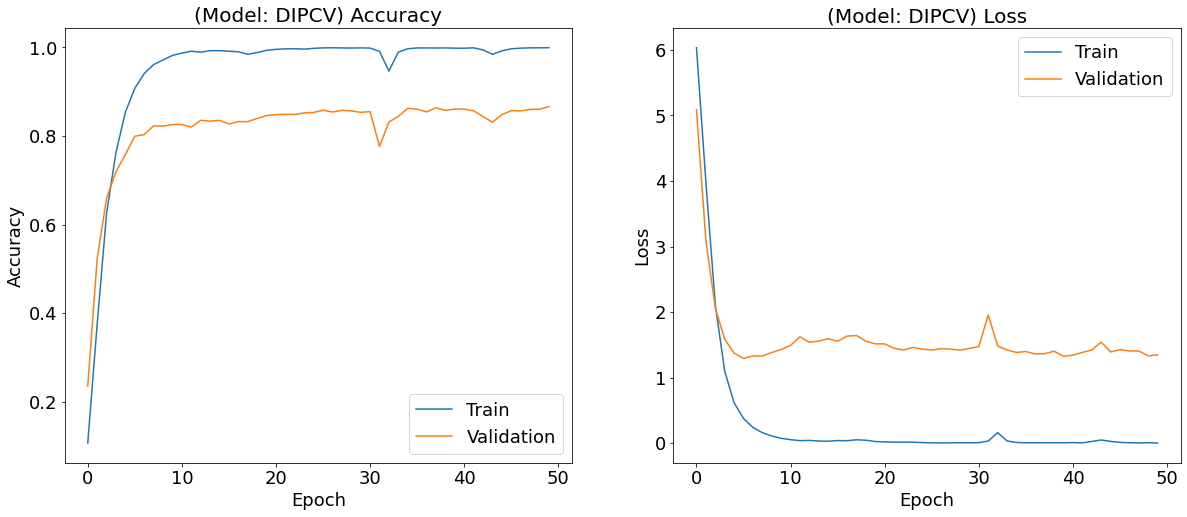

In [ ]:
DIPCV = Build_DIPCV_Model(Image_Size=Image_Size, Num_of_Channel=Num_Channels, Num_of_Attr=Num_Attrs, Num_of_Class=Num_Classes)
print(DIPCV.summary())
DIPCV.compile( optimizer = Adam(learning_rate=lr), loss = 'categorical_crossentropy', metrics = ['accuracy'] )

# Multiple Input 需要下面這行才能 train
tf.config.run_functions_eagerly(True)
DIPCV_History = DIPCV.fit(x=[tranImgDataset, tranRBAX], y=tranAns, validation_data=([valImgDataset, valRBAX], valAns),epochs=Epochs, batch_size=Batch_Size)

# Plot Training Results
Train_Accuracy = DIPCV_History.history['accuracy']
Val_Accuracy = DIPCV_History.history['val_accuracy']
Train_Loss = DIPCV_History.history['loss']
Val_Loss = DIPCV_History.history['val_loss']
epochs_range = range(Epochs)

import matplotlib.pyplot as plt

plt.figure( figsize=(20,8) )
plt.subplot( 1,2,1 )
plt.plot( range( len(Train_Accuracy) ), Train_Accuracy, label='Train' ) 
plt.plot( range( len(Val_Accuracy) ), Val_Accuracy, label='Validation' ) 
plt.legend( loc='lower right',fontsize=18)
plt.xlabel("Epoch", fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.yticks(fontsize=18)
plt.title( '(Model: DIPCV) Accuracy' , fontsize=20)

plt.subplot( 1,2,2 )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train' )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Validation' )
plt.xlabel("Epoch", fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.yticks(fontsize=18)
plt.legend( loc='upper right', fontsize=18)
plt.title( '(Model: DIPCV) Loss', fontsize=20)

plt.show()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 100, 100, 16)      448       
                                                                 
 Pool1 (MaxPooling2D)        (None, 50, 50, 16)        0         
                                                                 
 Conv2 (Conv2D)              (None, 50, 50, 32)        4640      
                                                                 
 Pool2 (MaxPooling2D)        (None, 25, 25, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 25, 25, 32)        9248      
                                                                 
 Pool3 (MaxPooling2D)        (None, 12, 12, 32)        0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
194/194 [==============================] - 6s 32ms/step - loss: 6.0124 - accuracy: 0.1148 - val_loss: 5.1155 - val_accuracy: 0.2249
Epoch 2/50
194/194 [==============================] - 6s 30ms/step - loss: 4.0099 - accuracy: 0.3620 - val_loss: 3.2865 - val_accuracy: 0.4927
Epoch 3/50
194/194 [==============================] - 6s 30ms/step - loss: 2.2723 - accuracy: 0.5826 - val_loss: 2.3129 - val_accuracy: 0.6178
Epoch 4/50
194/194 [==============================] - 6s 29ms/step - loss: 1.3321 - accuracy: 0.7114 - val_loss: 1.8858 - val_accuracy: 0.6636
Epoch 5/50
194/194 [==============================] - 6s 30ms/step - loss: 0.8448 - accuracy: 0.7997 - val_loss: 1.5835 - val_accuracy: 0.7187
Epoch 6/50
194/194 [==============================] - 6s 30ms/step - loss: 0.5569 - accuracy: 0.8598 - val_loss: 1.4313 - val_accuracy: 0.7673
Epoch 7/50
194/194 [==============================] - 6s 30ms/step - loss: 0.3790 - accuracy: 0.9035 - val_loss: 1.4210 - val_accuracy: 0.7789

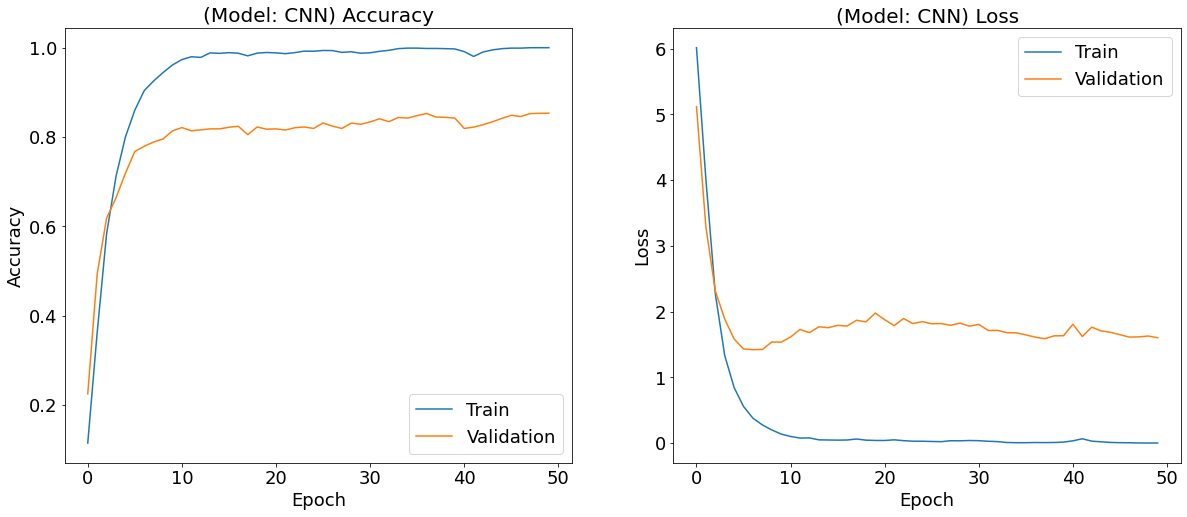

In [ ]:
CNN = Build_Pure_CNN_Model(Image_Size=Image_Size, Num_of_Channel=Num_Channels, Num_of_Class=Num_Classes)
CNN.summary()
CNN.compile( optimizer = Adam(learning_rate=lr), loss = 'categorical_crossentropy', metrics = ['accuracy'] )

CNN_History = CNN.fit(x=tranImgDataset, y=tranAns, validation_data=(valImgDataset, valAns),epochs=Epochs, batch_size=Batch_Size)

# Plot Training Results
Train_Accuracy = CNN_History.history['accuracy']
Val_Accuracy = CNN_History.history['val_accuracy']
Train_Loss = CNN_History.history['loss']
Val_Loss = CNN_History.history['val_loss']
epochs_range = range(Epochs)

plt.figure( figsize=(20,8) )
plt.subplot( 1,2,1 )
plt.plot( range( len(Train_Accuracy) ), Train_Accuracy, label='Train' ) 
plt.plot( range( len(Val_Accuracy) ), Val_Accuracy, label='Validation' ) 
plt.legend( loc='lower right',fontsize=18)
plt.xlabel("Epoch", fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.yticks(fontsize=18)
plt.title( '(Model: CNN) Accuracy' , fontsize=20)

plt.subplot( 1,2,2 )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train' )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Validation' )
plt.xlabel("Epoch", fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.yticks(fontsize=18)
plt.legend( loc='upper right', fontsize=18)
plt.title( '(Model: CNN) Loss', fontsize=20)

plt.show()

# Step 6: 了解信心水準

In [ ]:
Predicts=DIPCV.predict(x=[valImgDataset, valRBAX],verbose=1)

count_000_010 = 0
count_010_020 = 0
count_020_030 = 0
count_030_040 = 0
count_040_050 = 0
count_050_060 = 0
count_060_070 = 0
count_070_080 = 0
count_080_090 = 0
count_090_100 = 0

for each_prediction in Predicts:
  tmp_max = max(each_prediction)
  if tmp_max < 0.1:
    count_000_010 = count_000_010 + 1
  elif tmp_max >= 0.1 and tmp_max < 0.2:
    count_010_020 = count_010_020 + 1
  elif tmp_max >= 0.2 and tmp_max < 0.3:
    count_020_030 = count_020_030 + 1
  elif tmp_max >= 0.3 and tmp_max < 0.4:
    count_030_040 = count_030_040 + 1
  elif tmp_max >= 0.4 and tmp_max < 0.5:
    count_040_050 = count_040_050 + 1
  elif tmp_max >= 0.5 and tmp_max < 0.6:
    count_050_060 = count_050_060 + 1
  elif tmp_max >= 0.6 and tmp_max < 0.7:
    count_060_070 = count_060_070 + 1
  elif tmp_max >= 0.7 and tmp_max < 0.8:
    count_070_080 = count_070_080 + 1
  elif tmp_max >= 0.8 and tmp_max < 0.9:
    count_080_090 = count_080_090 + 1
  elif tmp_max >= 0.9 and tmp_max <= 1.0:
    count_090_100 = count_090_100 + 1

print("Model: DIPCV")
print("Level-01 Confidence ( 0% ~ 10%):", count_000_010)
print("Level-02 Confidence (10% ~ 20%):", count_010_020)
print("Level-03 Confidence (20% ~ 30%):", count_020_030)
print("Level-04 Confidence (30% ~ 40%):", count_030_040)
print("Level-05 Confidence (40% ~ 50%):", count_040_050)
print("Level-06 Confidence (50% ~ 60%):", count_050_060)
print("Level-07 Confidence (60% ~ 70%):", count_060_070)
print("Level-08 Confidence (70% ~ 80%):", count_070_080)
print("Level-09 Confidence (80% ~ 90%):", count_080_090)
print("Level-10 Confidence (90% ~100%):", count_090_100)
print("Total", count_000_010+count_010_020+count_020_030+count_030_040+count_040_050+count_050_060+count_060_070+count_070_080+count_080_090+count_090_100)

 1/97 [..............................] - ETA: 2s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


97/97 [==============================] - 1s 11ms/step
Model: DIPCV
Level-01 Confidence ( 0% ~ 10%): 0
Level-02 Confidence (10% ~ 20%): 1
Level-03 Confidence (20% ~ 30%): 16
Level-04 Confidence (30% ~ 40%): 30
Level-05 Confidence (40% ~ 50%): 49
Level-06 Confidence (50% ~ 60%): 79
Level-07 Confidence (60% ~ 70%): 69
Level-08 Confidence (70% ~ 80%): 82
Level-09 Confidence (80% ~ 90%): 117
Level-10 Confidence (90% ~100%): 2660
Total 3103


In [ ]:
Predicts=CNN.predict(x=valImgDataset,verbose=1)

count_000_010 = 0
count_010_020 = 0
count_020_030 = 0
count_030_040 = 0
count_040_050 = 0
count_050_060 = 0
count_060_070 = 0
count_070_080 = 0
count_080_090 = 0
count_090_100 = 0

for each_prediction in Predicts:
  tmp_max = max(each_prediction)
  if tmp_max < 0.1:
    count_000_010 = count_000_010 + 1
  elif tmp_max >= 0.1 and tmp_max < 0.2:
    count_010_020 = count_010_020 + 1
  elif tmp_max >= 0.2 and tmp_max < 0.3:
    count_020_030 = count_020_030 + 1
  elif tmp_max >= 0.3 and tmp_max < 0.4:
    count_030_040 = count_030_040 + 1
  elif tmp_max >= 0.4 and tmp_max < 0.5:
    count_040_050 = count_040_050 + 1
  elif tmp_max >= 0.5 and tmp_max < 0.6:
    count_050_060 = count_050_060 + 1
  elif tmp_max >= 0.6 and tmp_max < 0.7:
    count_060_070 = count_060_070 + 1
  elif tmp_max >= 0.7 and tmp_max < 0.8:
    count_070_080 = count_070_080 + 1
  elif tmp_max >= 0.8 and tmp_max < 0.9:
    count_080_090 = count_080_090 + 1
  elif tmp_max >= 0.9 and tmp_max <= 1.0:
    count_090_100 = count_090_100 + 1

print("Model: CNN")
print("Level-01 Confidence ( 0% ~ 10%):", count_000_010)
print("Level-02 Confidence (10% ~ 20%):", count_010_020)
print("Level-03 Confidence (20% ~ 30%):", count_020_030)
print("Level-04 Confidence (30% ~ 40%):", count_030_040)
print("Level-05 Confidence (40% ~ 50%):", count_040_050)
print("Level-06 Confidence (50% ~ 60%):", count_050_060)
print("Level-07 Confidence (60% ~ 70%):", count_060_070)
print("Level-08 Confidence (70% ~ 80%):", count_070_080)
print("Level-09 Confidence (80% ~ 90%):", count_080_090)
print("Level-10 Confidence (90% ~100%):", count_090_100)
print("Total", count_000_010+count_010_020+count_020_030+count_030_040+count_040_050+count_050_060+count_060_070+count_070_080+count_080_090+count_090_100)

 1/97 [..............................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


97/97 [==============================] - 1s 7ms/step
Model: CNN
Level-01 Confidence ( 0% ~ 10%): 0
Level-02 Confidence (10% ~ 20%): 0
Level-03 Confidence (20% ~ 30%): 4
Level-04 Confidence (30% ~ 40%): 29
Level-05 Confidence (40% ~ 50%): 42
Level-06 Confidence (50% ~ 60%): 73
Level-07 Confidence (60% ~ 70%): 76
Level-08 Confidence (70% ~ 80%): 75
Level-09 Confidence (80% ~ 90%): 144
Level-10 Confidence (90% ~100%): 2660
Total 3103
